In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

# Minist

In [2]:
import keras
import numpy as np
keras.__version__

Using TensorFlow backend.


'2.2.4'

## Dataset

In [3]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

### Visualize a sample of Training Data 

In [4]:
dataiter = iter(zip(train_images, train_labels))

In [5]:
img = next(dataiter); img[0].shape, img[1]

((28, 28, 1), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32))

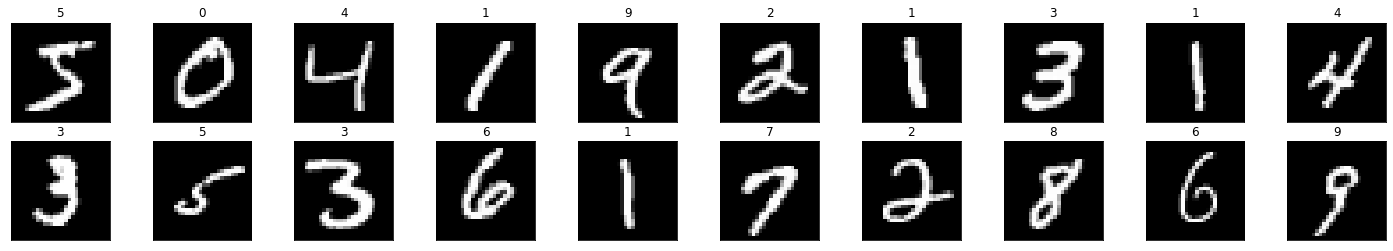

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
images, labels = train_images[:20], train_labels[:20]


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(np.argmax(labels[idx])))

### View an Image in More Detail 

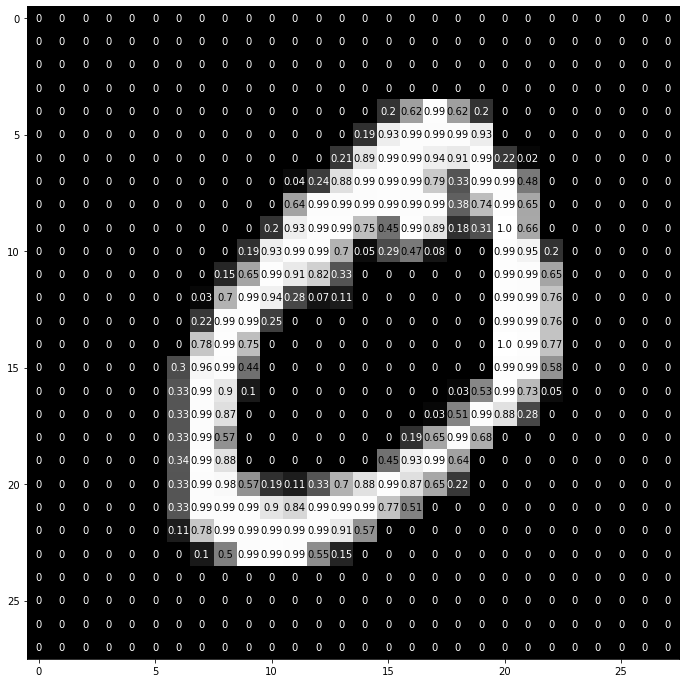

In [7]:
img = np.squeeze(train_images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Define the Network Architecture

The 6 lines of code below show you what a basic convnet looks like. It's a stack of Conv2D and MaxPooling2D layers. We'll see in a minute what they do concretely. Importantly, a convnet takes as input tensors of shape (image_height, image_width, image_channels) (not including the batch dimension). In our case, we will configure our convnet to process inputs of size (28, 28, 1), which is the format of MNIST images. We do this via passing the argument input_shape=(28, 28, 1) to our first layer.

In [9]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the architecture of our convnet so far:

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


You can see above that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as we go deeper in the network. The number of channels is controlled by the first argument passed to the Conv2D layers (e.g. 32 or 64).

The next step would be to feed our last output tensor (of shape (3, 3, 64)) into a densely-connected classifier network like those you are already familiar with: a stack of Dense layers. These classifiers process vectors, which are 1D, whereas our current output is a 3D tensor. So first, we will have to flatten our 3D outputs to 1D, and then add a few Dense layers on top:

In [11]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

We are going to do 10-way classification, so we use a final layer with 10 outputs and a softmax activation. Now here's what our network looks like:

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

As you can see, our (3, 3, 64) outputs were flattened into vectors of shape (576,), before going through two Dense layers.

Now, let's train our convnet on the MNIST digits. 

## Compile and Train

In [13]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

W0907 18:34:16.130638 140696396621632 deprecation_wrapper.py:119] From /home/khan74/.conda/envs/gwsurr/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0907 18:34:16.141122 140696396621632 deprecation_wrapper.py:119] From /home/khan74/.conda/envs/gwsurr/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



The steps for training/learning from a batch of data are described in the comments below:

1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

Keras wraps up all of these steps in one function: `model.fit()`. In the following we train for 5 epochs with a batch size of 64. Notice how the loss decreases and accuracy increases as we train.

In [14]:
model.fit(train_images, train_labels, epochs=5, batch_size=64)

W0907 18:34:17.317119 140696396621632 deprecation.py:323] From /home/khan74/.conda/envs/gwsurr/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0907 18:34:17.438325 140696396621632 deprecation_wrapper.py:119] From /home/khan74/.conda/envs/gwsurr/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/5
60000/60000 [==============================] - 33s 558us/step - loss: 0.6261 - acc: 0.8246
Epoch 2/5
60000/60000 [==============================] - 27s 450us/step - loss: 0.1691 - acc: 0.9493
Epoch 3/5
60000/60000 [==============================] - 14s 230us/step - loss: 0.1082 - acc: 0.9673
Epoch 4/5
60000/60000 [==============================] - 5s 77us/step - loss: 0.0840 - acc: 0.9743
Epoch 5/5
60000/60000 [==============================] - 23s 385us/step - loss: 0.0698 - acc: 0.9789


## Test the Trained Network

Finally, we test our trained model on previously unseen test data and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

In [15]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 5s 501us/step


In [16]:
print('Test Accuracy: {:.4f} and Test Loss: {:.4f}'.format(test_acc, test_loss))

Test Accuracy: 0.9810 and Test Loss: 0.0627


In [17]:
# initialize lists to monitor test accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

pred = model.predict(test_images, verbose=0)
pred = np.argmax(pred, axis=-1)
labels = np.argmax(test_labels, axis=-1)

for i in range(len(pred)):
    correct = pred[i] == labels[i]
    class_correct[labels[i]] += correct
    class_total[labels[i]] += 1
    
    
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))  

Test Accuracy of     0: 99% (973/980)
Test Accuracy of     1: 99% (1131/1135)
Test Accuracy of     2: 99% (1022/1032)
Test Accuracy of     3: 99% (1001/1010)
Test Accuracy of     4: 98% (968/982)
Test Accuracy of     5: 98% (881/892)
Test Accuracy of     6: 98% (939/958)
Test Accuracy of     7: 97% (999/1028)
Test Accuracy of     8: 94% (921/974)
Test Accuracy of     9: 96% (975/1009)

Test Accuracy (Overall): 98% (9810/10000)


Lets see predictions on individual test images. Since `model.predict` expects a batch of images, i.e, a 4-d tensor, we expand the first dimension of the test image before feeding into model.

Text(0.5, 1.0, 'Prediction: 7')

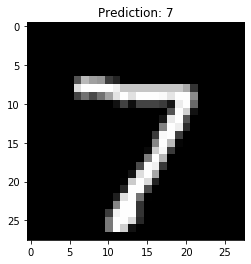

In [18]:
index = 0
pred = model.predict(np.expand_dims(test_images[index], axis=0)); pred = np.argmax(pred)
plt.imshow(np.squeeze(test_images[index]), cmap='gray')
plt.title('Prediction: {}'.format(pred))

In [19]:
#Define a python generator
import itertools

def generator(images, labels, batch_size):
    iterable_1 = iter(images)
    iterable_2 = iter(labels)
    while True:
        l1 = tuple(itertools.islice(iterable_1, 0, batch_size))
        l2 = tuple(itertools.islice(iterable_2, 0, batch_size))
        if l1 and l2:
            yield np.vstack(np.expand_dims(l1, axis=0)), np.vstack(np.expand_dims(l2, axis=0))
        else:
            break
            
test_generator = generator(test_images, test_labels, 20)

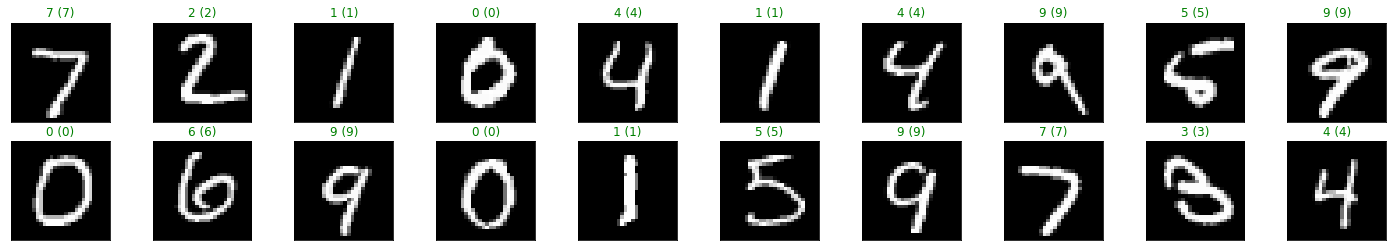

In [20]:
images, labels = next(test_generator)
labels = np.argmax(labels, axis=-1)

# get sample outputs
preds = model.predict(images)
# convert output probabilities to predicted class
preds = np.argmax(preds, axis=-1)

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx]), str(labels[idx])),
                 color=("green" if preds[idx]==labels[idx] else "red"))

## Interpret

In [41]:
from keras import Model

emb_model = Model(input = model.input, output = model.get_layer('dense_1').output)

/home/khan74/.conda/envs/gwsurr/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=Tensor("de...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
emb_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
__________

In [43]:
activations = emb_model.predict(test_images, verbose=1)
predictions = model.predict(test_images, verbose=1); labels = predictions.argmax(axis=-1)

10000/10000 [==============================] - 3s 325us/step


In [44]:
activations.shape

(10000, 64)

Spectral_r, gnuplot2

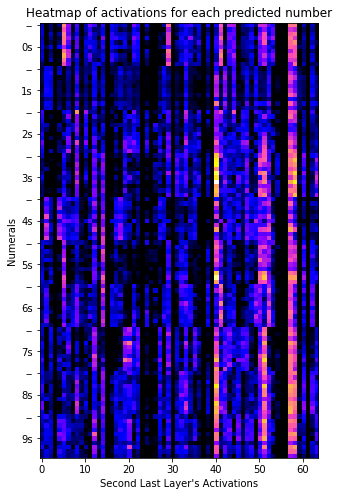

In [45]:
# Stack 10 examples of activation vectors for each numeral
seq = []
for i in range(10):
    seq.append(activations[labels==i][:10])
seq = np.vstack(seq)


# Plot heatmap for the example activations
plt.figure(figsize=(8,8))
plt.imshow(seq, interpolation='nearest', cmap=plt.cm.gnuplot2)
plt.yticks(np.arange(0,100, 5), ['--','0s','--','1s','--','2s','--','3s','--','4s','--','5s','--','6s',
                                 '--','7s','--','8s','--','9s','--'])
plt.xlabel("Second Last Layer's Activations")
plt.ylabel('Numerals')
plt.title('Heatmap of activations for each predicted number')
plt.show()

#### Tensorboard

In [46]:
import io

with io.open('vecs.tsv', 'w', encoding='utf-8') as out_v:
    for embed in activations:
        out_v.write('\t'.join([str(x) for x in embed]) + "\n")
        
with io.open('meta.tsv', 'w', encoding='utf-8') as out_m:
    for l in labels:
        out_m.write(str(l) + "\n")

#### tSNE 

In [44]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [47]:
tsne = TSNE(n_components=3, verbose=1).fit_transform(activations)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.021s...
[t-SNE] Computed neighbors for 10000 samples in 7.026s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.395028
[t-SNE] KL divergence after 10 iterations with early exaggeration: 97.489616
[t-SNE] KL divergence after 1000 iterations: 1.370488


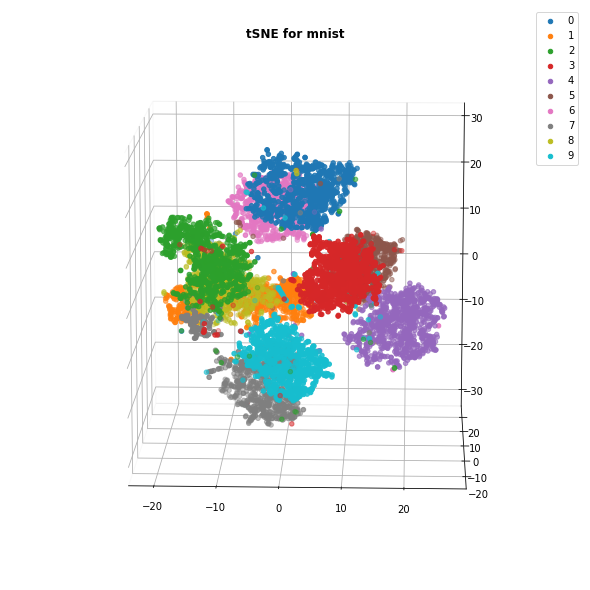

In [57]:
#Plot tSNE

fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)

ax.scatter3D(tsne[:,0][labels==0], tsne[:,2][labels==0], tsne[:,1][labels==0], label='0')
ax.scatter3D(tsne[:,0][labels==1], tsne[:,2][labels==1], tsne[:,1][labels==1], label='1')
ax.scatter3D(tsne[:,0][labels==2], tsne[:,2][labels==2], tsne[:,1][labels==2], label='2')
ax.scatter3D(tsne[:,0][labels==3], tsne[:,2][labels==3], tsne[:,1][labels==3], label='3')
ax.scatter3D(tsne[:,0][labels==4], tsne[:,2][labels==4], tsne[:,1][labels==4], label='4')
ax.scatter3D(tsne[:,0][labels==5], tsne[:,2][labels==5], tsne[:,1][labels==5], label='5')
ax.scatter3D(tsne[:,0][labels==6], tsne[:,2][labels==6], tsne[:,1][labels==6], label='6')
ax.scatter3D(tsne[:,0][labels==7], tsne[:,2][labels==7], tsne[:,1][labels==7], label='7')
ax.scatter3D(tsne[:,0][labels==8], tsne[:,2][labels==8], tsne[:,1][labels==8], label='8')
ax.scatter3D(tsne[:,0][labels==9], tsne[:,2][labels==9], tsne[:,1][labels==9], label='9')

ax.legend(loc='upper right')
ax.view_init(elev=12, azim=-88)

font = {'fontname':'Times New Roman'}
plt.title('tSNE for mnist', fontsize=12, fontweight="bold", pad=15, **font)


#Set Ticks
#ax.xaxis.set_major_locator(MultipleLocator(10))
#ax.yaxis.set_major_locator(MultipleLocator(10))
#ax.zaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False